In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase
from ase.build import bulk

from mpl_toolkits import mplot3d
import mpi4py

seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

In [3]:
# Set up unit cell with (a, b, c, alpha, beta, gamma)
sic = pc.BathCell(3.073, 3.073, 10.053, 90, 90, 120, 'deg')
# z axis in cell coordinates
sic.zdir = [0, 0, 1]
# Next, user has to define positions of atoms in the unit cell. It is done with BathCell.add_atoms function. It takes an unlimited number of arguments, each argument is a tuple. First element of the tuple is the name of the atom, second - list of xyz coordinates either in cell units (if keyword type='cell', default value) or in Angstrom (if keyword type='angstrom'). Returns BathCell.atoms dictionary, which contains list of coordinates for each type of elements.
# position of atoms
sic.add_atoms(('Si', [0.00000000, 0.00000000, 0.1880]),
              ('Si', [0.00000000, 0.00000000, 0.6880]),
              ('Si', [0.33333333, 0.66666667, 0.4380]),
              ('Si', [0.66666667, 0.33333333, 0.9380]),
              ('C', [0.00000000, 0.00000000, 0.0000]),
              ('C', [0.00000000, 0.00000000, 0.5000]),
              ('C', [0.33333333, 0.66666667, 0.2500]),
              ('C', [0.66666667, 0.33333333, 0.7500]))

# isotopes
sic.add_isotopes(('29Si', 0.047), ('13C', 0.011))

# defect position in cell units
vsi_cell = [0, 0, 0.1880]
vc_cell = [0, 0, 0]

# Generate bath spin positions
atoms = sic.gen_supercell(200, remove=[('Si', vsi_cell),
                                       ('C', vc_cell)],
                          seed=seed)

# Prepare rotation matrix to align with z axis of generated atoms
# This matrix, acting on the [0, 0, 1] in Cartesian coordinates of the GIPAW output,
# Should produce [a, b, c] vector, aligned with the z-direction of the BathCell
M = np.array([[0, 0, -1],
              [0, -1, 0],
              [-1, 0, 0]])

# Position of (0,0,0) point in cell coordinates
center = [0.6, 0.5, 0.5]
# Read GIPAW results
exatoms = pc.read_qe('axial/pw.in',
                     hyperfine='axial/gipaw.out',
                     center=center, rotation_matrix=M,
                     rm_style='col',
                     isotopes={'C':'13C', 'Si':'29Si'})

position = sic.to_cartesian(vsi_cell)
##########################################################################################
# Now basal stuff
##########################################################################################

# Coordinates of vacancies in cell coordinates (note that Vsi is not located in the first unit cell)
vsi_cell = -np.array([1 / 3, 2 / 3, 0.0620])
vc_cell = np.array([0, 0, 0])

sic.zdir = [0, 0, 1]

# Rotation matrix for DFT supercell
R = pc.rotmatrix([0, 0, 1], sic.to_cartesian(vsi_cell - vc_cell))

sic.zdir = vsi_cell - vc_cell ### ????

# Generate bath spin positions
sic.add_isotopes(('29Si', 0.047), ('13C', 0.011))
atoms = sic.gen_supercell(200, remove=[('Si', vsi_cell),
                                       ('C', vc_cell)],
                          seed=seed)

M = np.array([[0, 0, -1],
              [0, -1, 0],
              [-1, 0, 0]])

# Position of (0,0,0) point in cell coordinates
center = np.array([0.59401, 0.50000, 0.50000])

# Read GIPAW results
exatoms = pc.read_qe('basal/pw.in',
                     hyperfine='basal/gipaw.out',
                     center=center, rotation_matrix=(M.T @ R),
                     rm_style='col',
                     isotopes={'C':'13C', 'Si':'29Si'})


# isotopes
sic.add_isotopes(('29Si', 1), ('13C', 1))
allcell = sic.gen_supercell(50, remove=[('Si', vsi_cell),
                                        ('C', vc_cell)],
                            seed=seed)

indexes, ext_indexes = pc.same_bath_indexes(allcell, exatoms, 0.2, True)
print(f"There are {indexes.size} same elements."
      f" Size of the DFT supercell is {exatoms.size}")

# ---OUTPUT---
# There are 1438 same elements. Size of the DFT supercell is 1438




# # Note, that because the 14C isotope doesn’t have a spin, PyCCE does not find it in common isotopes, and raises a warning. We have to provide SpinType for it separately, or define the properties as follows:
# atoms['14C'].gyro = 0
# atoms['14C'].spin = 0

# Setting up the Simulator

# Setting up CCE calculations

# order = 3
r_bath = 30
r_dipole = 8
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]


There are 1438 same elements. Size of the DFT supercell is 1438


In [4]:
# print('Cell\n', diamond.cell)
# print('\nAtoms\n', diamond.atoms)

In [5]:
##########################################################################################
# ZFS Parametters of NV center in diamond
#############################################
# ZFS D parameter
start = 1.334 * 1e6
stop = 1.334 * 1e7
# start = 1e-20
# stop = 1e-19
num = 3

D_list = np.logspace(np.log10(start), np.log10(stop), num=num) # in kHz

# D_list = [1.334 * (10**(3+i)) for i in range(0,num)]

# D_list = np.linspace(start, stop, num=num)

# D_list = [1] # Note for later, very low values of D give remarkably high coherence??

# D_list = [19390]
print("D_list: ", D_list)
#############################################
# ZFS E parameter
E_start = 18.4 * 1e2
E_stop = 18.4 * 1e4
E_num = 3
E_list = np.logspace(np.log10(E_start), np.log10(E_stop), num=E_num) 
# E_list = np.linspace(E_start, E_stop, num=E_num)
# E_list = [i*0.138 for i in D_list]
# E = 0.0184 * 1e6 VV in SiC

# E_list = [139.24798] # Note for later, this value of E give remarkably high coherence??

##########################################################################################
### Other parameters

# Covergence Parameters
order_list = [1,2,3,4]
r_bath_list = [20, 30, 40, 50, 60]
r_dipole_list = [4, 6, 8, 10]





# The code already knows most exsiting isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
            ('13C',  1 / 2,  6.72828),
            ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

# Time points
time_space = np.linspace(0, 1, 101)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 0

##########################################################################################
# Mag. Field (Bx By Bz)
b = np.array([0,0, 500])  # in G
##########################################################################################
B = 0
N = 0

coherence_list = []
coherence_dict = {}
order_master_results = {}

D_list:  [ 1334000.       4218478.39866 13340000.     ]


In [6]:
for o in order_list:
    print(f"Running for order: {o}")
    
    # Dictionary for the current order
    order_dict = {}
    
    for idx, D in enumerate(D_list):
        print(str(1 + idx) + "/" + str(len(D_list)))
        
        for idx2, E in enumerate(E_list):
            print("E run: " + str(1 + idx2) + "/" + str(len(E_list)))
            
            # Set the Simulator object
            calc = pc.Simulator(1, position, bath=atoms, external_bath=exatoms,
                                D=D, E=E, pulses=N, alpha=0, beta=1,
                                r_bath=r_bath, r_dipole=r_dipole)

            calc.center.generate_states()
            calc.generate_clusters(o)  # Use the current order value

            # Calculate coherence function
            l_generatilze = calc.compute(time_space, nbstates=20, seed=seed,
                                         method='gcce',
                                         quantity='coherence', as_delay=False,
                                         parallel=True,)

            # Store coherence values for the current combination of D and E
            key = (D, E)
            order_dict[key] = np.abs(l_generatilze)
            
    # Store results for the current order in the master dictionary
    order_master_results[o] = order_dict

Running for order: 1
1/3
E run: 1/3


/Users/markoneill/Desktop/Physics/SS/Capstone/VScode Capstone Folder/Capstone_environment/lib/python3.10/site-packages/numpy/ma/core.py:467: ComplexWarning: Casting complex values to real discards the imaginary part
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


E run: 2/3
E run: 3/3
2/3
E run: 1/3
E run: 2/3
E run: 3/3
3/3
E run: 1/3
E run: 2/3
E run: 3/3
Running for order: 2
1/3
E run: 1/3
E run: 2/3
E run: 3/3
2/3
E run: 1/3
E run: 2/3
E run: 3/3
3/3
E run: 1/3
E run: 2/3
E run: 3/3
Running for order: 3
1/3
E run: 1/3
E run: 2/3
E run: 3/3
2/3
E run: 1/3
E run: 2/3
E run: 3/3
3/3
E run: 1/3
E run: 2/3
E run: 3/3
Running for order: 4
1/3
E run: 1/3


KeyboardInterrupt: 

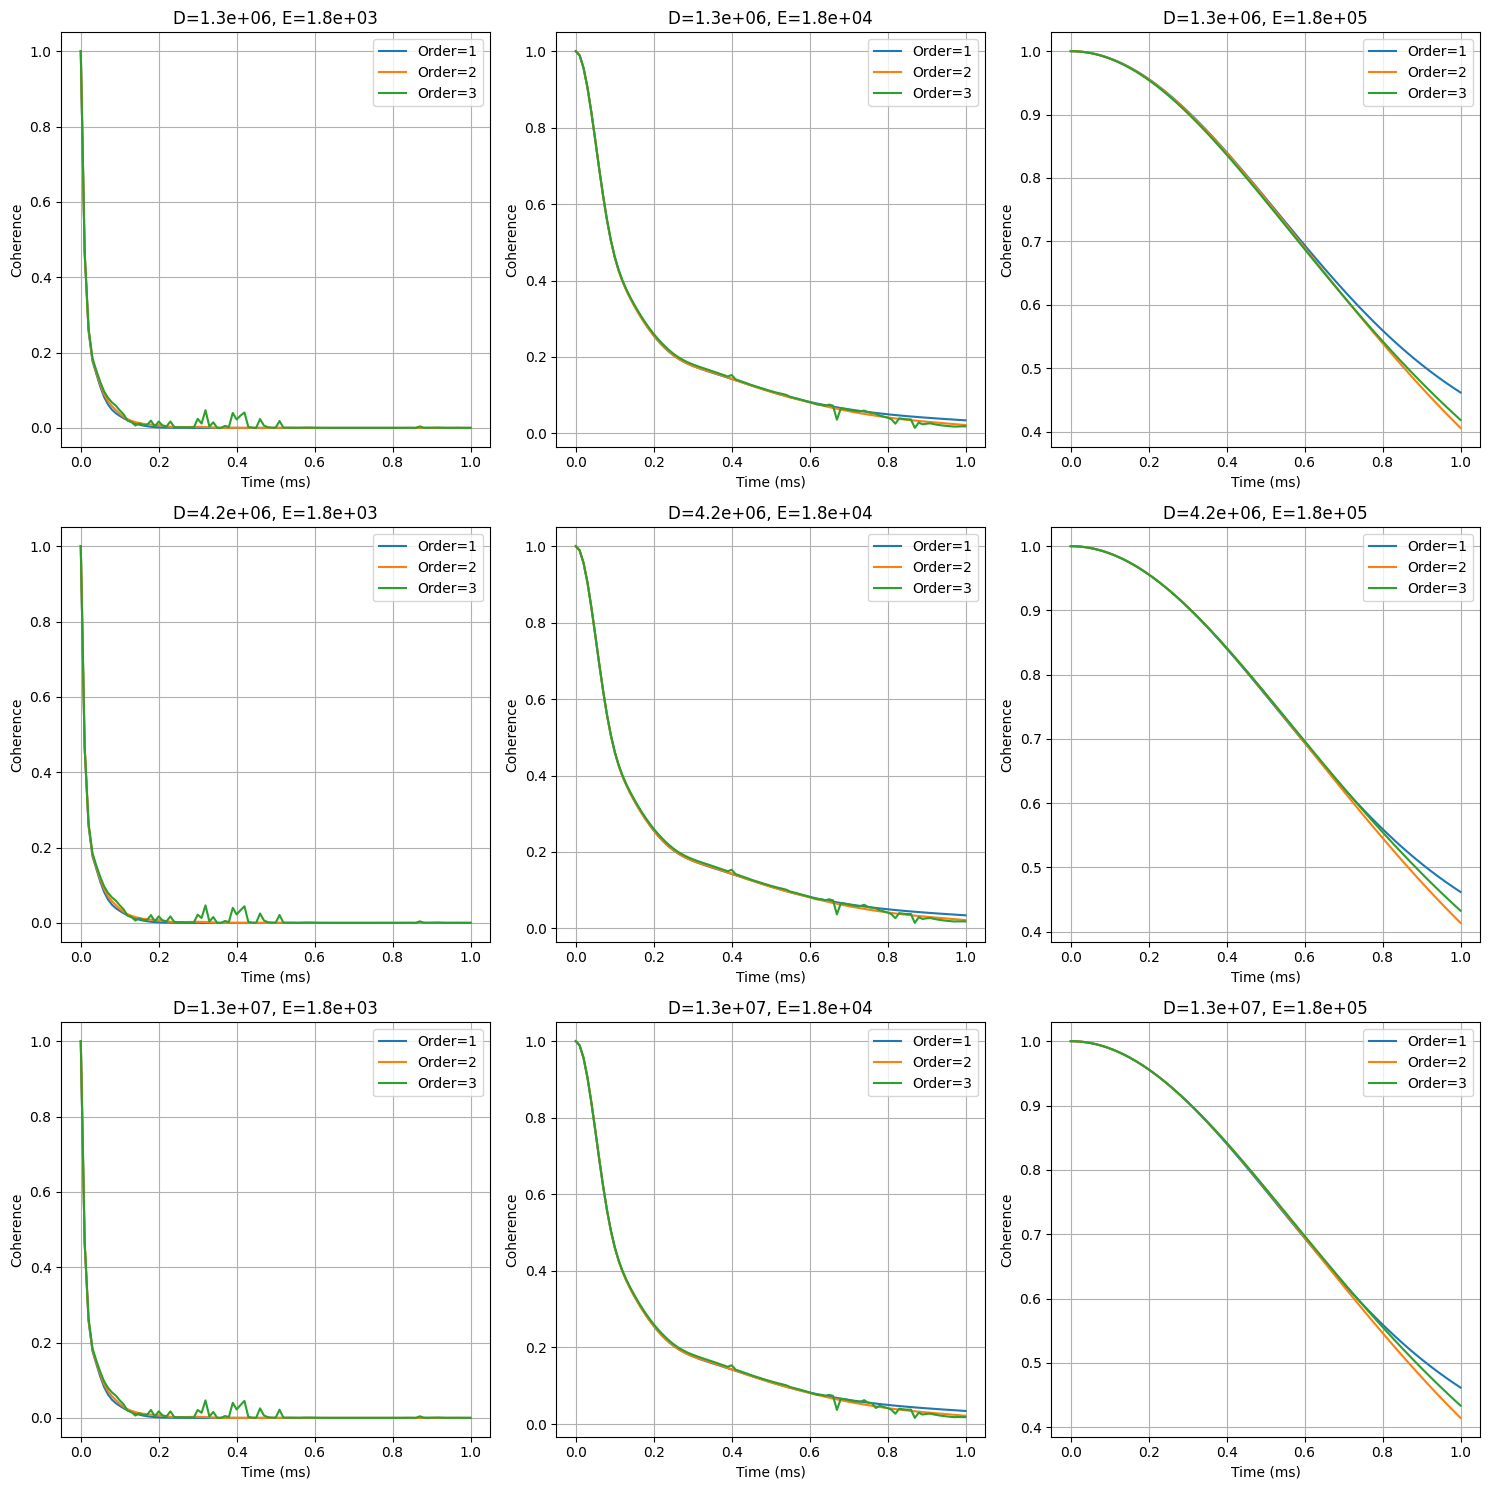

In [8]:

# Extract unique order values
unique_orders = sorted(order_master_results.keys())

# Determine the grid layout
num_D = len(D_list)
num_E = len(E_list)

# Create a figure with subplots
fig, axes = plt.subplots(num_D, num_E, figsize=(15, 15))

# Ensure 'axes' is always a 2D array, even if num_D or num_E is 1
if num_D == 1: 
    axes = np.expand_dims(axes, axis=0)
if num_E == 1:
    axes = np.expand_dims(axes, axis=1)

# Loop through all combinations of D and E
for i, D in enumerate(D_list):
    for j, E in enumerate(E_list):
        ax = axes[i, j]
        
        # Plot coherence for each order for the current D and E combination
        for order in unique_orders:
            coherence_for_order = order_master_results[order][(D, E)]
            ax.plot(time_space, coherence_for_order, label=f'Order={order}')
        
        ax.set_title(f'D={D:.1e}, E={E:.1e}')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Coherence')
        ax.legend()
        ax.grid(True)  # Optional

plt.tight_layout()
plt.show()

/var/folders/lw/t9zjwk2n3gz9vr06983n8b040000gn/T/ipykernel_9311/4016763022.py:2: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(time / T2) ** beta)
/var/folders/lw/t9zjwk2n3gz9vr06983n8b040000gn/T/ipykernel_9311/4016763022.py:2: RuntimeWarning: invalid value encountered in power
  return np.exp(-(time / T2) ** beta)


Error fitting for D = 1.3e+06 kHz, E = 5.8e+03: Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Error fitting for D = 2.4e+06 kHz, E = 5.8e+03: Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Error fitting for D = 4.2e+06 kHz, E = 5.8e+03: Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Error fitting for D = 7.5e+06 kHz, E = 5.8e+03: Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Error fitting for D = 1.3e+07 kHz, E = 5.8e+03: Optimal parameters not found: Number of calls to function has reached maxfev = 600.


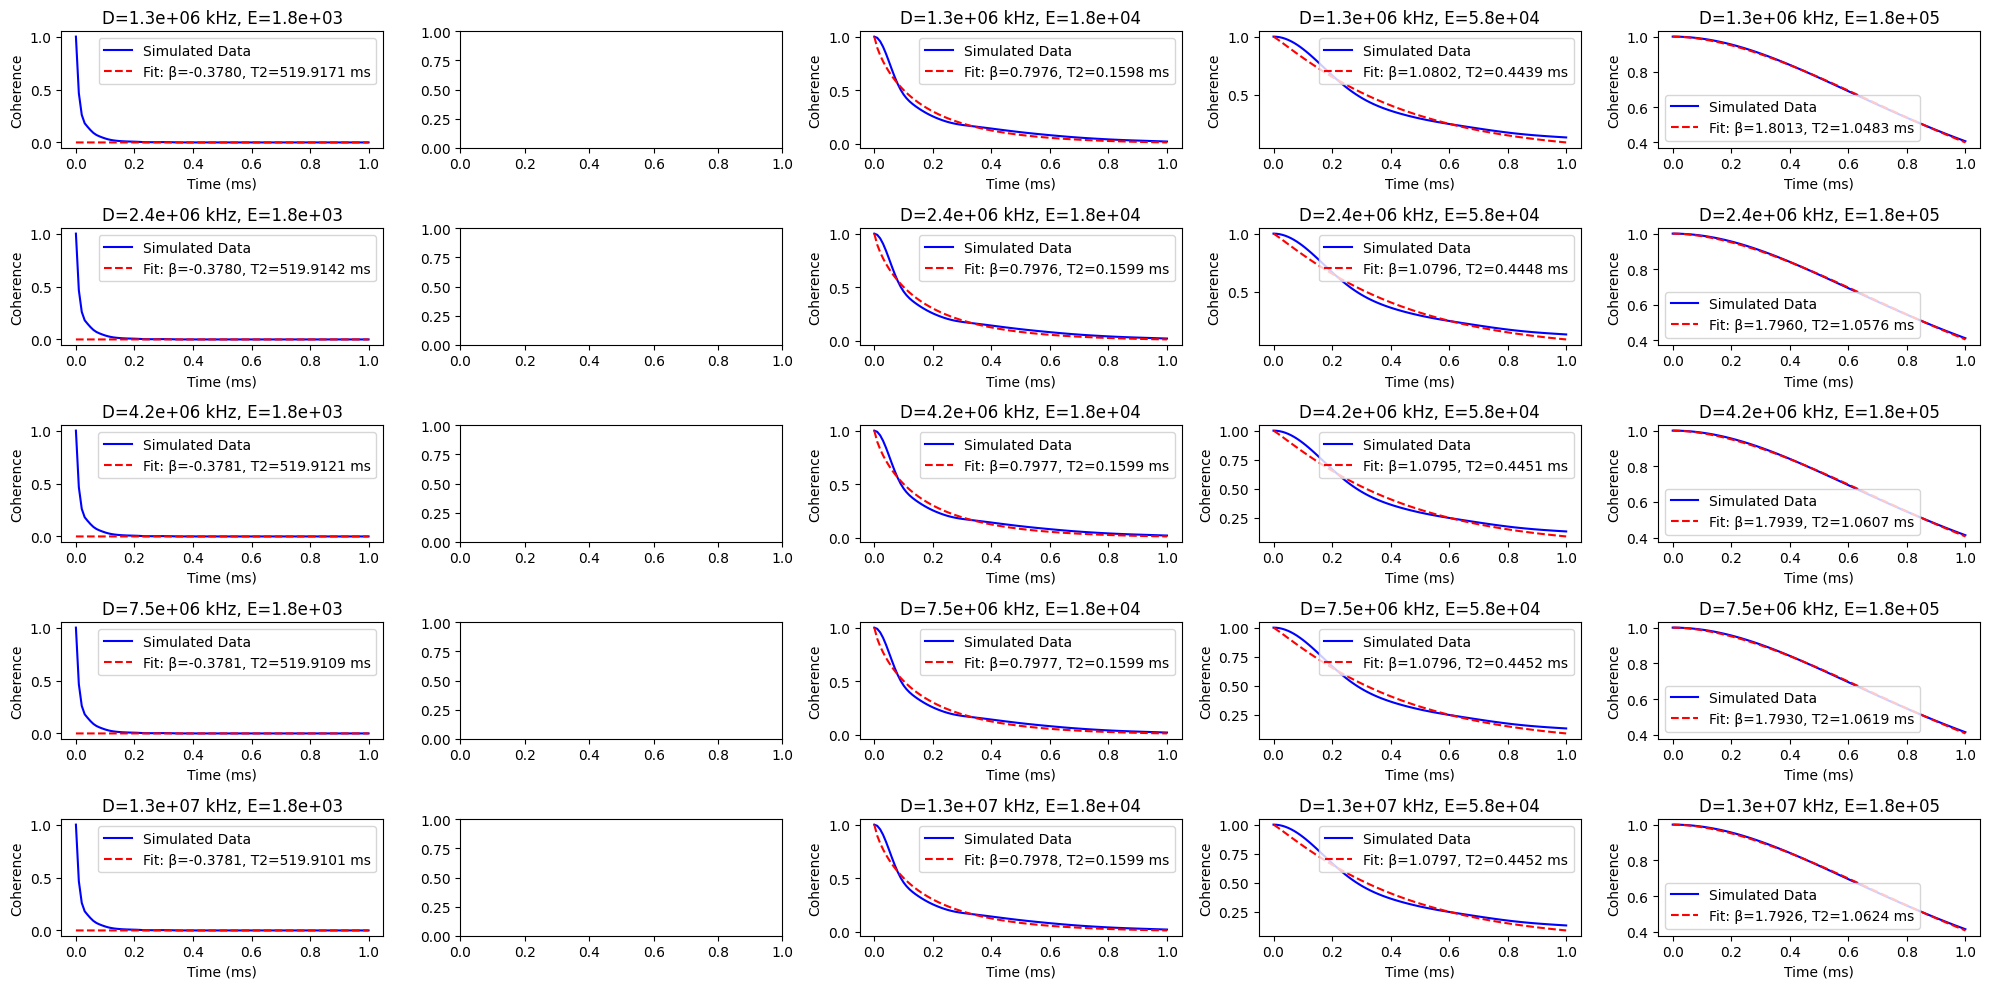

In [288]:
def coherence_time_func(time, beta, T2):
    return np.exp(-(time / T2) ** beta)

from scipy.optimize import curve_fit

# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

T2_values = {}
beta_values = {}

rows = len(unique_D_values)
cols = len(unique_E_values)
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

for i, D in enumerate(unique_D_values):
    for j, E in enumerate(unique_E_values):
        # Extract coherence data for the given D and E value
        coherence_data = coherence_dict[(D, E)]
        
        try:
            popt, _ = curve_fit(coherence_time_func, time_space, coherence_data, p0=(1, 1))
            beta_fitted, T2_fitted = popt
            beta_values[(D, E)] = beta_fitted
            T2_values[(D, E)] = T2_fitted

            ax = axes[i, j]
            ax.plot(time_space, coherence_data, 'b-', label='Simulated Data')
            ax.plot(time_space, coherence_time_func(time_space, *popt), 'r--', label=f'Fit: β={beta_fitted:.4f}, T2={T2_fitted:.4f} ms')
            ax.set_title(f'D={D:.1e} kHz, E={E:.1e}')
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Coherence')
            ax.legend()

        except Exception as e:
            print(f"Error fitting for D = {D:.1e} kHz, E = {E:.1e}: {e}")
            beta_values[(D, E)] = None
            T2_values[(D, E)] = None

plt.tight_layout()
plt.show()

# for (D, E), T2 in T2_values.items():
#     print(f"D = {D} kHz, E = {E}: T2 = {T2:.4f} ms")


In [252]:
def sanitize_T2_values(T2_values):
    """
    For any T2 value above 20ms, set the value to None.
    """
    for key, value in T2_values.items():
        if value is not None and value > 20:
            T2_values[key] = None
    return T2_values

T2_values = sanitize_T2_values(T2_values)

# for (D, E), T2 in T2_values.items():
    # print(f"D = {D} kHz, E = {E}: T2 = {T2 if T2 is not None else 'None'} ms")

/Users/markoneill/Desktop/Physics/SS/Capstone/VScode Capstone Folder/Capstone_environment/lib/python3.10/site-packages/numpy/ma/core.py:467: ComplexWarning: Casting complex values to real discards the imaginary part
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


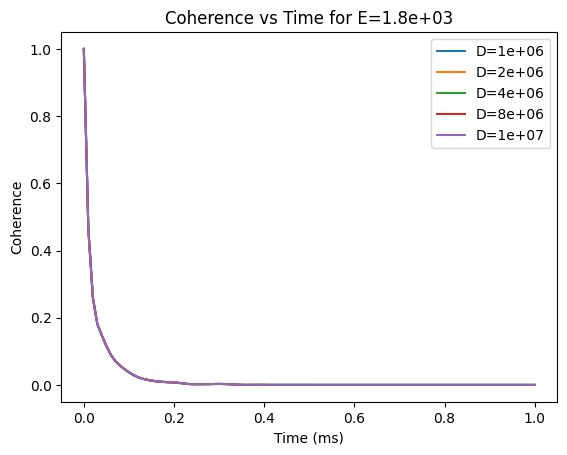

In [270]:
# Extract coherence values for the smallest E value
smallest_E = min(unique_E_values)
coherence_for_smallest_E = [coherence_dict[(D, smallest_E)] for D in unique_D_values]

plt.figure()
for i, D_val in enumerate(unique_D_values):
    plt.plot(time_space, coherence_for_smallest_E[i], label=f'D={D_val:.0e}')
    
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
plt.legend()
plt.title(f'Coherence vs Time for E={smallest_E:.1e}')
# plt.ylim(0,10)
plt.show()


/Users/markoneill/Desktop/Physics/SS/Capstone/VScode Capstone Folder/Capstone_environment/lib/python3.10/site-packages/numpy/ma/core.py:467: ComplexWarning: Casting complex values to real discards the imaginary part
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


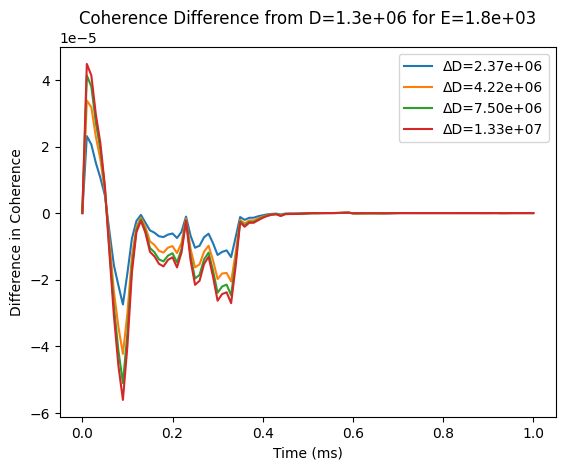

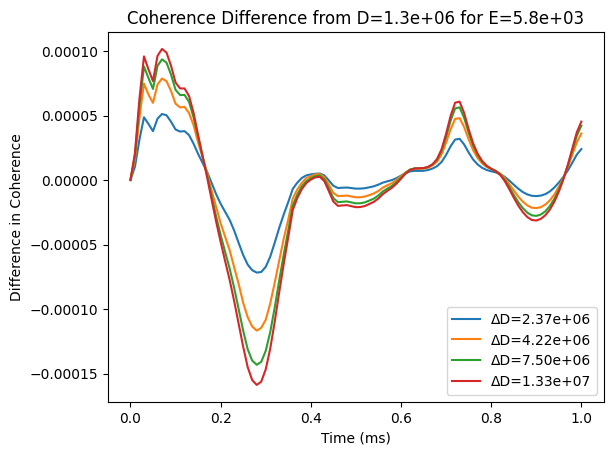

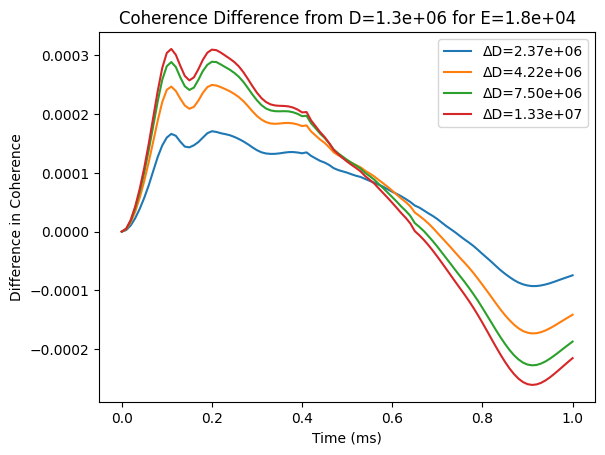

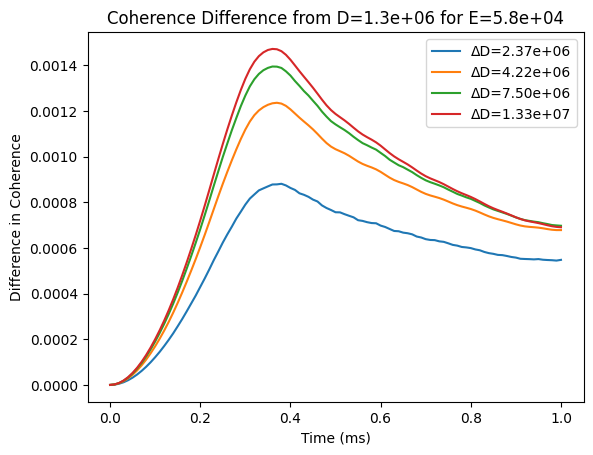

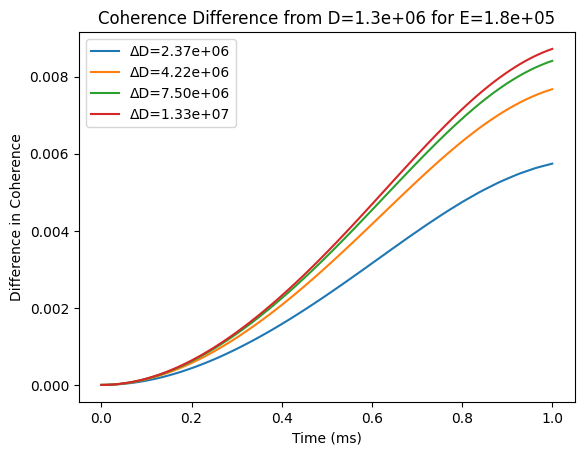

In [273]:
# Visualize difference in coherence for different D values

# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Reference coherence for smallest D
ref_D_value = min(unique_D_values)

# Iterate over each unique E value
for E in unique_E_values:
    # The reference coherence changes for each E. Update the ref_coherence for each E.
    ref_coherence = coherence_dict[(ref_D_value, E)]

    # plt.figure(figsize=(10,7))
    for D in unique_D_values:
        if D == ref_D_value:  # Don't plot the difference for the reference D
            continue
        coherence_for_DE = coherence_dict[(D, E)]
        
        # Plot the difference
        difference = coherence_for_DE - ref_coherence
        plt.plot(time_space, difference, label=f'ΔD={D:.2e}')
    
    plt.title(f'Coherence Difference from D={ref_D_value:.1e} for E={E:.1e}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Difference in Coherence')
    plt.legend()
    plt.show()


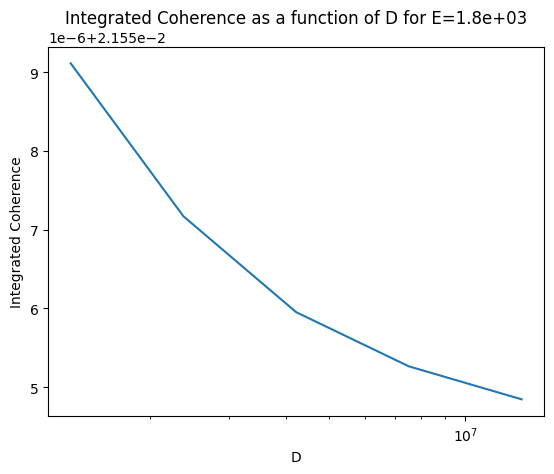

In [274]:
def integrate(x_list, y_list):
    """
    Integrate a list of y values with respect to a list of x values.
    """
    return np.trapz(y_list, x_list)

# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Reference coherence for smallest E
ref_E_value = min(E_list)

# Integrate each coherence curve for each D at the reference E value
integrated_coherence = [integrate(time_space, coherence_dict[(D, ref_E_value)]) for D in unique_D_values]

# Plot the integrated coherence as a function of D
plt.figure()
plt.semilogx(unique_D_values, integrated_coherence)
plt.xlabel('D')
plt.ylabel('Integrated Coherence')
plt.title(f'Integrated Coherence as a function of D for E={ref_E_value:.1e}')
plt.show()


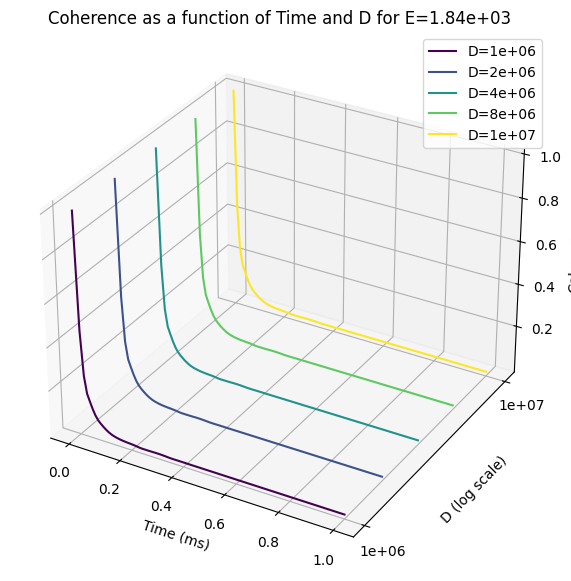

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


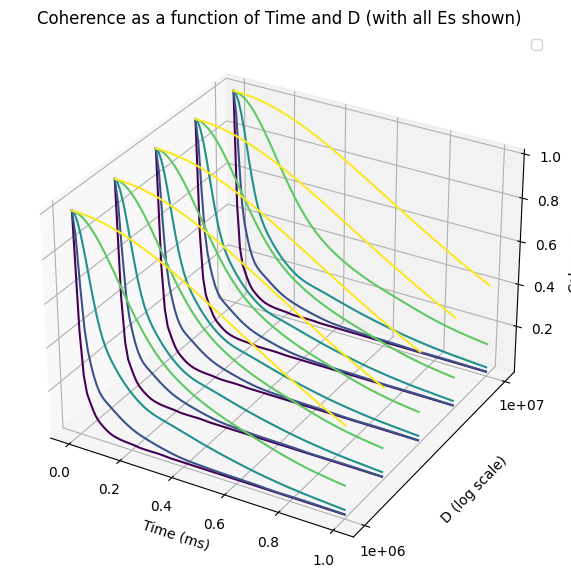

In [276]:
# 3d plot of coherence as a function of D and E (only showing plots for smallest E value)
# Convert time_space and unique_D_values to meshgrid
TIME, D = np.meshgrid(time_space, unique_D_values)

# Extract coherence values for the smallest E value
smallest_E = min(unique_E_values)
coherence_matrix_for_smallest_E = np.array([coherence_dict[(D, smallest_E)] for D in unique_D_values])

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting coherence for each D value at the smallest E
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_D_values)))
for i, D_val in enumerate(unique_D_values):
    ax.plot(TIME[i], np.log10([D_val] * len(TIME[i])), coherence_matrix_for_smallest_E[i], color=colors[i], label=f'D={D_val:.0e}')

# Setting Y-axis (D-axis) ticks and labels for log scale
yticks = np.arange(np.log10(min(unique_D_values)), np.log10(max(unique_D_values)) + 1, 1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{10**int(tick):.0e}" for tick in yticks])

ax.set_xlabel('Time (ms)')
ax.set_ylabel('D (log scale)')
ax.set_zlabel('Coherence')
ax.set_title(f'Coherence as a function of Time and D for E={smallest_E:.2e}')
ax.legend()

plt.show()








##########################################################################################
# For all E values, plot coherence as a function of D and time

# Convert time_space and unique_D_values to meshgrid
TIME, D = np.meshgrid(time_space, unique_D_values)

# Extract coherence values for each (D, E) pair and store them as a list of 2D arrays
coherence_matrices = [np.array([coherence_dict[(D, E)] for D in unique_D_values]) for E in unique_E_values]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting each E value as a collection of lines (one for each D)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_E_values)))
for i, E in enumerate(unique_E_values):
    for j, D_val in enumerate(unique_D_values):
        ax.plot(TIME[j], np.log10([D_val] * len(TIME[j])), coherence_matrices[i][j], color=colors[i] )#, label=f'E={E}' if j == 0 else "")

# Setting Y-axis (D-axis) ticks and labels for log scale
yticks = np.arange(np.log10(min(unique_D_values)), np.log10(max(unique_D_values)) + 1, 1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{10**int(tick):.0e}" for tick in yticks])

ax.set_xlabel('Time (ms)')
ax.set_ylabel('D (log scale)')
ax.set_zlabel('Coherence')
ax.set_title('Coherence as a function of Time and D (with all Es shown)')
ax.legend()

plt.show()




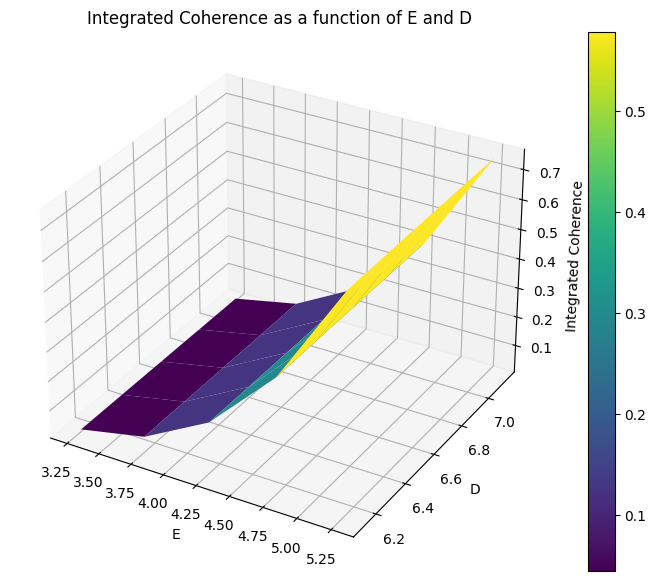

In [278]:
# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Create meshgrid for E and D
E, D = np.meshgrid(unique_E_values, unique_D_values)

# Transform values to logarithmic scale
log_unique_D_values = np.log10(unique_D_values)
log_unique_E_values = np.log10(unique_E_values)

# Create meshgrid for log(E) and log(D)
logE, logD = np.meshgrid(log_unique_E_values, log_unique_D_values)

# Calculate integrated coherence for each E, D pair
Z = np.array([[integrate(time_space, coherence_dict[(d, e)]) for e in unique_E_values] for d in unique_D_values])

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(logE, logD, Z, cmap='viridis')
fig.colorbar(surf)

ax.set_xlabel('E')
ax.set_ylabel('D')
ax.set_zlabel('Integrated Coherence')
ax.set_title('Integrated Coherence as a function of E and D')
# ax.view_init(elev=35, azim=135)

plt.show()


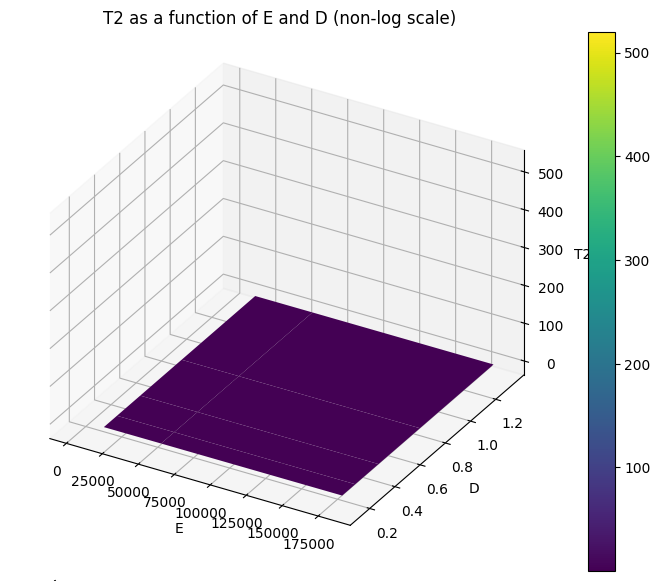

In [279]:
# Create meshgrid for E and D
E, D = np.meshgrid(unique_E_values, unique_D_values)

# Use T2_values to populate Z array
Z = np.empty(E.shape)

for i, d in enumerate(unique_D_values):
    for j, e in enumerate(unique_E_values):
        Z[i, j] = T2_values.get((d, e), np.nan)  # Use .get() method to retrieve the T2 value or default to NaN if not found

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')

surf = ax.plot_surface(E, D, Z, cmap='viridis')
fig.colorbar(surf)

ax.set_xlabel('E')
ax.set_ylabel('D')
ax.set_zlabel('T2')
ax.set_title('T2 as a function of E and D (non-log scale)')

plt.show()


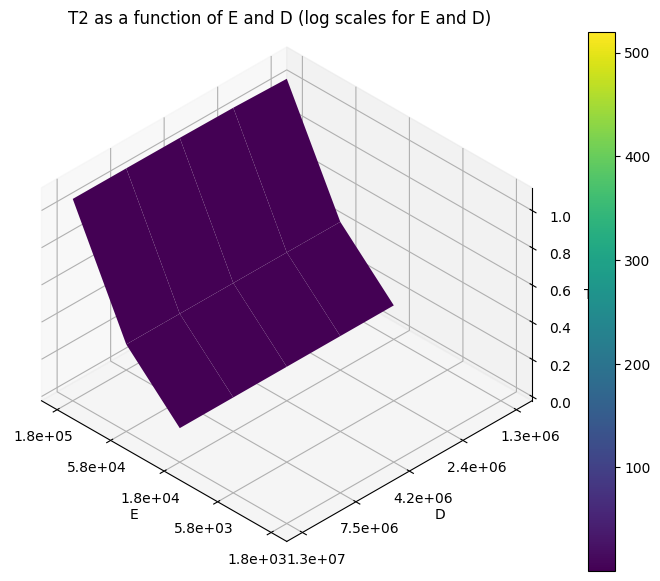

In [281]:
# Transform values to logarithmic scale
log_unique_D_values = np.log10(unique_D_values)
log_unique_E_values = np.log10(unique_E_values)

# Create meshgrid for log(E) and log(D)
logE, logD = np.meshgrid(log_unique_E_values, log_unique_D_values)

Z = np.empty(logE.shape)  # create an empty array with the same shape as logE and logD

# Populate the Z array directly from T2_values
for i, d in enumerate(unique_D_values):
    for j, e in enumerate(unique_E_values):
        Z[i, j] = T2_values.get((d, e), np.nan)  # Retrieve the T2 value from the dictionary or default to NaN if not found

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')

surf = ax.plot_surface(logE, logD, Z, cmap='viridis')
fig.colorbar(surf)

# Set axis labels
ax.set_xlabel('E')
ax.set_ylabel('D')
ax.set_zlabel('T2')
ax.set_title('T2 as a function of E and D (log scales for E and D)')

# Manually set ticks and tick labels to reflect original scale
ax.set_xticks(log_unique_E_values)
ax.set_yticks(log_unique_D_values)

# Format tick labels in scientific notation
ax.set_xticklabels([f"{value:.1e}" for value in unique_E_values])
ax.set_yticklabels([f"{value:.1e}" for value in unique_D_values])

ax.view_init(elev=35, azim=135)
ax.set_zlim(0,1.1)

plt.show()
